In [3]:
train_file = "/Users/test/Downloads/UPDATED_NLP_COURSE/06-Deep-Learning/train_qa.txt"

In [4]:
test_file = "/Users/test/Downloads/UPDATED_NLP_COURSE/06-Deep-Learning/test_qa.txt"

In [5]:
import pickle
import numpy as np

In [6]:
with open(train_file, 'rb') as f:
  train_data = pickle.load(f)

In [7]:
with open(test_file, 'rb') as f:
  test_data = pickle.load(f)

In [8]:
all_data = test_data + train_data

In [10]:
vocab = set()
for story, question, answer in all_data:
  vocab = vocab.union(set(story))
  vocab = vocab.union(set(question))

In [12]:
vocab.add("no")

In [13]:
vocab.add("yes")

In [14]:
vocab_len = len(vocab) +1

In [16]:
all_story_lens = [len(data[0]) for data in all_data]

In [17]:
max_story = max(all_story_lens)

In [18]:
max_question_len = max(len(data[1]) for data in all_data )

In [21]:
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [22]:
train_story_text = []
train_question_text = []
train_answers = []

In [24]:
for story, question, answer in train_data:
  train_story_text.append(story)
  train_question_text.append(question)
  train_answers.append(answer)

In [25]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [27]:
def vectorize_stories(data, word_index= tokenizer.word_index, max_story_len=max_story, max_question_len=max_question_len ):
  
  X= []
  Xq = []
  Y = []
  
  for story, query, answer in data:
    x = [word_index[word.lower()] for word in story]
    xq = [word_index[word.lower()] for word in query]
    
    y = np.zeros(len(word_index) +1)
    
    X.append(x)
    Xq.append(xq)
    Y.append(y)
    

  return (pad_sequences(X, maxlen=max_story_len), pad_sequences(Xq, maxlen=max_question_len),np.array(Y) )

In [28]:
inputs_train, queries_train, answer_train = vectorize_stories(train_data)

In [29]:
inputs_test, queries_test, answer_test = vectorize_stories(test_data)

In [30]:
inputs_test

array([[ 0,  0,  0, ..., 20,  9, 15],
       [ 0,  0,  0, ..., 20,  3, 15],
       [ 0,  0,  0, ..., 20,  3, 15],
       ...,
       [ 0,  0,  0, ..., 20, 26, 15],
       [ 0,  0,  0, ..., 20,  3, 15],
       [ 0,  0,  0, ..., 26, 25, 15]], dtype=int32)

In [32]:
answer_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
sum(answer_test)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [35]:
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate

In [41]:
input_seq = Input((max_story,))
question = Input((max_question_len,))

In [36]:
vocab_size = len(vocab) +1

In [37]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))

In [38]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

In [39]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [42]:
input_encoded_m = input_encoder_m(input_seq)
input_encoded_c = input_encoder_c(input_seq)
question_encoded = question_encoder(question)

In [43]:
match = dot([input_encoded_m, question_encoded], axes =(2,2))
match = Activation('softmax')(match)

In [44]:
response = add([match, input_encoded_c])
response = Permute((2,1))(response)

In [45]:
answer = concatenate([response, question_encoded])

In [46]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [48]:
from keras.layers import LSTM

answer = LSTM(32)(answer)

In [49]:
answer = Dropout(0.5)(answer)

answer = Dense(vocab_size)(answer)

In [50]:
answer = Activation('softmax')(answer)

model = Model([input_seq, question], answer)

In [51]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

In [53]:
history = model.fit([inputs_train,queries_train], answer_train, batch_size=32, epochs=120, validation_data=([inputs_test, queries_test], answer_test))

Epoch 1/100


2024-04-22 13:04:10.555230: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


313/313 [==============================] - 4s 8ms/step - loss: 0.0000e+00 - accuracy: 0.3068 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/100
313/313 [==============================] - 5s 16ms/step - loss: 0.0000e+00 - accuracy: 0.3016 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.2841 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/100
313/313 [==============================] - 2s 6ms/step - loss: 0.0000e+00 - accuracy: 0.2720 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/100
313/313 [==============================] - 6s 18ms/step - loss: 0.0000e+00 - accuracy: 0.2480 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.2309 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/100
313/313 [==============================] - 3s 8ms/step - loss: 0.0000e+00 - accuracy: 0.2182

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


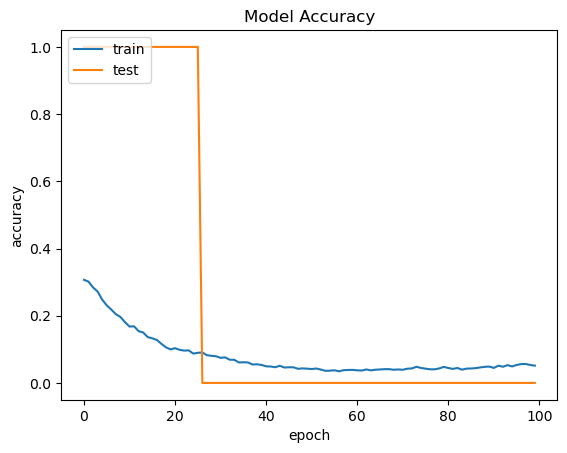

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [55]:
preds = model.predict(([inputs_test, queries_test]))

32/32 [==============================] - 1s 4ms/step


In [56]:
preds.shape

(1000, 38)

In [57]:
val_max = np.argmax(preds[0])

In [58]:
for key, val in tokenizer.word_index.items():
  if val == val_max:
    k = key

In [59]:
k

'left'

In [61]:
preds[0][val_max]

0.041426826

In [62]:
my_story = "John left the kitchen . Sandra Dropped the football in the garden . "

In [63]:
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'Dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [64]:
my_question = "Is the football in the garden ?"

In [65]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [66]:
mydata = [(my_story.split(), my_question.split(), 'yes')]

In [67]:
my_story, my_ques, my_ans = vectorize_stories(mydata)

In [68]:
pred_results = model.predict([my_story, my_ques])

1/1 [==============================] - 0s 140ms/step


In [69]:
for key, val in tokenizer.word_index.items():
  if val == val_max:
    k = key

In [70]:
k

'left'